
# Filtering and pre-processing

Given the AnnData matrix created in the previous step, run some filtering and tooling steps for later processes.

In [1]:
import os
import collections

import numpy as np
import pandas
import scanpy
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

results_file = './write/tgfb1-2.h5ad'  # the file that will store the analysis results

/home/ubuntu/.local/lib/python3.6/site-packages/numba/errors.py:105: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


scanpy==1.4 anndata==0.6.19 numpy==1.16.2 scipy==1.2.1 pandas==0.24.2 scikit-learn==0.20.3 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


Load the AnnData matrix previously created. We have duplicate gene names in this matrix because of the merge step. We will only keep one of them.

In [2]:
adata = anndata.read_h5ad("./write/merged-final.h5ad")

In [3]:
adata.var["gene_names"] = adata.var["gene_names-S1"]
del adata.var["gene_names-S1"]
del adata.var["gene_names-S2"]

In [4]:
for i, gn in enumerate(adata.var.index):
    if gn == "ACTA2":
        print(i)

7423


In [5]:
adata

AnnData object with n_obs × n_vars = 12267 × 36246 
    obs: 'batch', 'cellular_barcode'
    var: 'gene_names'
    layers: 'ambiguous', 'spliced', 'unspliced'

In [6]:
adata.var["gene_names"] == "ACTA2"

index
A1BG           False
A1BG-AS1       False
A1CF           False
A2M            False
A2M-AS1        False
A2ML1          False
A2ML1-AS1      False
A2MP1          False
A4GALT         False
A4GNT          False
AAAS           False
AACS           False
AACSP1         False
AADAC          False
AADACL2        False
AADACL2-AS1    False
AADACL3        False
AADACL4        False
AADACP1        False
AADAT          False
AAGAB          False
AAK1           False
AAMDC          False
AAMP           False
AANAT          False
AAR2           False
AARD           False
AARS           False
AARS2          False
AARSD1         False
               ...  
ZSCAN30        False
ZSCAN31        False
ZSCAN32        False
ZSCAN4         False
ZSCAN5A        False
ZSCAN5B        False
ZSCAN5C        False
ZSCAN5DP       False
ZSCAN9         False
ZSWIM1         False
ZSWIM2         False
ZSWIM3         False
ZSWIM4         False
ZSWIM5         False
ZSWIM5P2       False
ZSWIM6         False
ZSWIM7 

(array([4.999e+03, 1.310e+02, 4.000e+01, 8.000e+00, 7.000e+00, 5.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <a list of 10 Patch objects>)

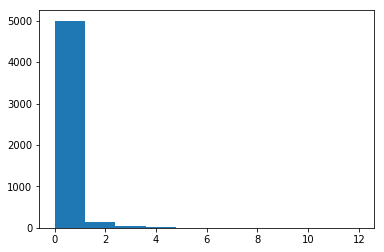

In [8]:
plt.hist(adata[:,adata.var["gene_names"] == "ACTA2"][adata.obs["batch"] == "S1",:].X.tolist())

(array([6.602e+03, 2.580e+02, 1.070e+02, 8.300e+01, 1.200e+01, 4.000e+00,
        3.000e+00, 2.000e+00, 1.000e+00, 1.000e+00]),
 array([ 0. ,  1.3,  2.6,  3.9,  5.2,  6.5,  7.8,  9.1, 10.4, 11.7, 13. ]),
 <a list of 10 Patch objects>)

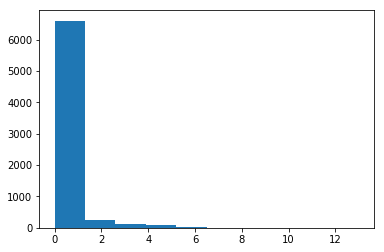

In [9]:
plt.hist(adata[:,adata.var["gene_names"] == "ACTA2"][adata.obs["batch"] == "S2",:].X.tolist())

ValueError: Shape does not fit.

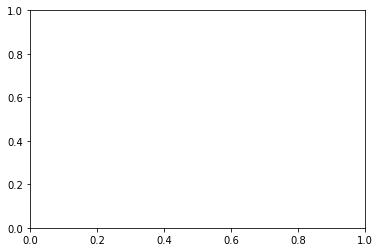

In [13]:
plt.hist(adata[:, 7423].X)

## Identifying total count

From this data set, we will compute the total number of RNA molecules found in each cell.

In [ ]:
adata.obs['n_counts'] = np.ravel(adata.X.sum(axis=1))

In [ ]:
adata.obs['n_counts']

In [ ]:
sc.pl.violin(adata, ['n_counts'], jitter=0.4)

## Visualizing most expressed genes

Create a plot showing the genes that are found the most across our data set.

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20)

## Filtering by gene and cell count

As a first filtering step, we filter out cells that have fewer than 300 expressed genes.

In [ ]:
sc.pp.filter_cells(adata, min_genes=200)

We will now filter out genes that are expressed in fewer than 3 cells. Before doing so, we want to save a version of the complete list of genes for future analysis.

In [ ]:
original_genes = list(adata.var["gene_names"])
sc.pp.filter_genes(adata, min_cells=3)

After this step, we have gotten additional information, including `n_genes`, automatically computing the number of genes found to be expressed in each cell.

## Identifying ratio of mitochondrial genes

We want to compute a ratio of mitochondrial genes to total count for each cell. This is important for quality control.

Citing from "Simple Single Cell" workflows [(Lun, McCarthy & Marioni, 2017)](https://master.bioconductor.org/packages/release/workflows/html/simpleSingleCell.html#examining-gene-level-metrics):

> High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

In [ ]:
mito_genes = adata.var_names.str.startswith('MT-')
adata.obs['percent_mito'] = np.ravel(np.sum(
    adata[:, mito_genes].X, axis=1)) / np.ravel(np.sum(adata.X, axis=1))

Get number of mito genes in our gene set.

In [ ]:
len([i for i in mito_genes if i])

Get number of mito gene counts per cell.

In [ ]:
np.sum(adata[:, mito_genes].X, axis=1)

Show violin plot of mito gene count ratio.

In [ ]:
sc.pl.violin(adata, ['percent_mito'],
             jitter=0.4)

After these analyses, we have managed to compute the following metrics for our cells:

In [ ]:
adata.obs[:15]

## Filtering by ratio of mitochondrial genes and total count

Filter out cells whose mitochondrial gene ratio or total count is too high based on these violin plots.

Scatter plot and matrix before filtering:

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
adata

Remove cells that have total counts >100000 or mitochondrial gene ratio >0.05. These are good numbers per the violin plots above.

In [ ]:
adata = adata[adata.obs['n_counts'] < 100000, :]
adata = adata[adata.obs['percent_mito'] < 0.05, :]

Scatter plot, violin plot and matrix after filtering:

In [ ]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

In [ ]:
sc.pl.violin(adata, ['n_counts', 'percent_mito'],
             jitter=0.4, multi_panel=True)

In [ ]:
adata

# Normalize total count

Now that we have filtered out outliers, we can normalize the count matrix by total count to reduce this source of variability. We will correct for the library size of the data matrix by rescaling it to 10000 reads per cell. Let us look at the unnormalized counts and perform the normalization:

In [ ]:
adata.X.sum(1)

In [ ]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

Let us inspect the new counts:

In [ ]:
adata.X.sum(1)

## Log total counts

Prior knowledge of microarray and bulkRNAseq means we know that a lot of effects are linear in the log of the total count, so it is a good idea to log the data now.

In [ ]:
sc.pp.log1p(adata)

In [ ]:
adata.X.sum(1)

## Identifying and filtering highly variable genes.

An important filtering metric is dispersion. Highly variable genes can be identified by this metric and filtered as important for future processing.

In [ ]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=4, min_disp=0)

In [ ]:
sc.pl.highly_variable_genes(adata)

Number of highly variable genes compared with non-highly variable genes:

In [ ]:
collections.Counter(adata.var["highly_variable"])

Let's save our genes list before filtering out non highly variable genes and do the actual filtering:

In [ ]:
before_highly_variable_genes = list(adata.var["gene_names"])

In [ ]:
adata = adata[:, adata.var['highly_variable']]

In [ ]:
adata.uns["genes_original"] = original_genes
adata.uns["genes_before_highly_variable"] = before_highly_variable_genes

In [ ]:
adata

## Scale data set

Gene variance alone could be a source of noise during analysis. We will scale the data set to achieve unit variance and zero mean, clipping values exceeding std 10.

In [ ]:
sc.pp.scale(adata, max_value=10)

In [ ]:
adata.X.sum(1)

## Save filtered matrix to file

In [ ]:
adata.write(results_file)